Info: Nathan Shammah, RIKEN, nathan.shammah@gmail.com

# Open Quantum Dynamics with QuTiP
 
 
 We use QuTiP's solvers to study the open dynamics of a quantum system evolving in time. 
 
 
 - #### Lindblad Master Equation
 
  - #### Lindblad Master Equation: Time evolution
 
  - #### Lindblad Master Equation: steady-state solution
 
- #### Stochastic Dynamics: Quantum Trajectories with Monte Carlo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

### Define the operators and Hamiltonian

We consider the spin-boson system, which is a prototypical model of light-matter interaction in cavity quantum electrodynamics (cQED): a single two-level system coupled to a single mode of the photonic field. Its Hamiltonian is described by

\begin{eqnarray}
H &=& \omega_c a^\dagger a + \frac{\omega_0}{2}\sigma_z
+\frac{g}{2}\sigma_x\left(a+a^\dagger\right)+\frac{\omega_x}{2}\sigma_x,
\end{eqnarray}

where we added also the possibility of the system of a classical drive onto the system at a frequency $\omega_x$.

In [2]:
# spins
sx_reduced = sigmax()
sy_reduced = sigmay()
sz_reduced = sigmaz()
sp_reduced = sigmap()
sm_reduced = sigmam()

# photons
nph = 4
a_reduced = destroy(nph)

# tensor space
sz = tensor(sz_reduced,qeye(nph))
sx = tensor(sx_reduced,qeye(nph))
sm = tensor(sm_reduced,qeye(nph))
sp = sm.dag()
a = tensor(qeye(2), a_reduced)

# hamiltonians
wc = 1
w0 = 0.5*wc
g = 0.1*w0
wx = 0.2*w0
Hcav = wc*a.dag()*a
Hspin = w0*sz #+ wx*sx
Hint =  g*sx*(a+a.dag())
HintCheck =  g*tensor(sx_reduced,a_reduced+a_reduced.dag())
H = Hcav + Hspin + Hint
np.testing.assert_(Hint == HintCheck)

### Define the initial state

The initial state of the system is given by 
\begin{eqnarray}
\rho&=&\rho_\text{spin}\otimes\rho_\text{phot}
\end{eqnarray}
and in the case of a initially pure state, 
\begin{eqnarray}
\rho&=&|\psi\rangle_\text{spin}\otimes|\psi\rangle_\text{phot}
\end{eqnarray}


In [3]:
# initial state
psi0_spin = basis(2,0)
psi0_phot = basis(nph,nph-int(nph/2))
psi0 = tensor(psi0_spin,psi0_phot)
rho0 = ket2dm(psi0)

# times at which to calculate the variables
tlist = np.linspace(0,50,2000)

### Lindblad master equation: $\texttt{mesolve}$

We now consider the time evolution of the open quantum system, in which $\rho$ is dissipatively coupled to a spin and photonic bath,

\begin{eqnarray}
\frac{d}{dt}\rho =-i\lbrack H,\rho\rbrack+\gamma\mathcal{D}_{[\sigma_-]}\rho+\kappa\mathcal{D}_{[a]}\rho.
\end{eqnarray}

In [4]:
kappa = 0.3
gamma = 0.3

my_options = Options(average_states = True, store_states = True)
results = mesolve(H, psi0, tlist, 
                  c_ops=[np.sqrt(kappa)*a,np.sqrt(gamma)*sz], 
                  e_ops=[a.dag()*a,sz], 
                  options=my_options, progress_bar=True)

# store time evoluted variables
nph_t = results.expect[0]
sz_t = results.expect[1]
rho_t = results.states

10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.04s. Est. time left: 00:00:00:00
30.0%. Run time:   0.06s. Est. time left: 00:00:00:00
40.0%. Run time:   0.08s. Est. time left: 00:00:00:00
50.0%. Run time:   0.10s. Est. time left: 00:00:00:00
60.0%. Run time:   0.12s. Est. time left: 00:00:00:00
70.0%. Run time:   0.14s. Est. time left: 00:00:00:00
80.0%. Run time:   0.16s. Est. time left: 00:00:00:00
90.0%. Run time:   0.18s. Est. time left: 00:00:00:00
Total run time:   0.20s


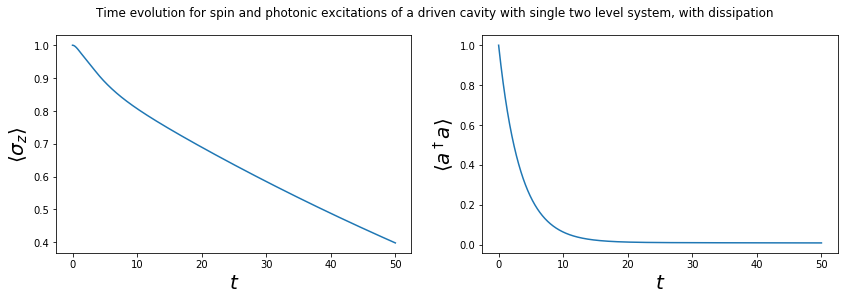

In [5]:
fs=20
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(tlist, sz_t)
plt.xlabel(r"$t$",fontsize=fs)
plt.ylabel(r"$\langle \sigma_z \rangle$",fontsize=fs)
plt.subplot(122)
plt.plot(tlist, nph_t/nph/0.5)
plt.xlabel(r"$t$",fontsize=fs)
plt.ylabel(r"$\langle a^\dagger a \rangle$",fontsize=fs)
plt.suptitle("Time evolution for spin and photonic excitations of a driven cavity with single two level system, with dissipation")
plt.show()
plt.close()

### Steady state solver: $\texttt{steadystate}$

In [6]:
rhoss = steadystate(H,[np.sqrt(kappa)*a,np.sqrt(gamma)*sz])
nph_ss= expect(a.dag()*a,rhoss)
sz_ss= expect(sz,rhoss)

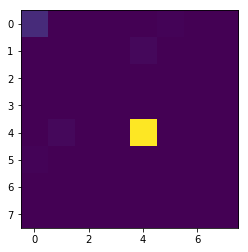

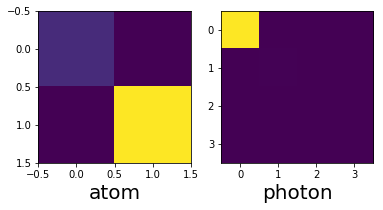

In [7]:
plt.figure()
plt.imshow(abs(rhoss.full()))
plt.show()
plt.close()
plt.figure()
plt.subplot(121)
plt.imshow(abs(ptrace(rhoss,0).full()))
plt.xlabel("atom",fontsize=fs)
plt.subplot(122)
plt.imshow(abs(ptrace(rhoss,1).full()))
plt.xlabel("photon",fontsize=fs)
plt.show()
plt.close()

## Liouvillian structure

We can derive thermodynamical properties of the out-of-equilibrium system by studying the spectrum of the Liouvillian.

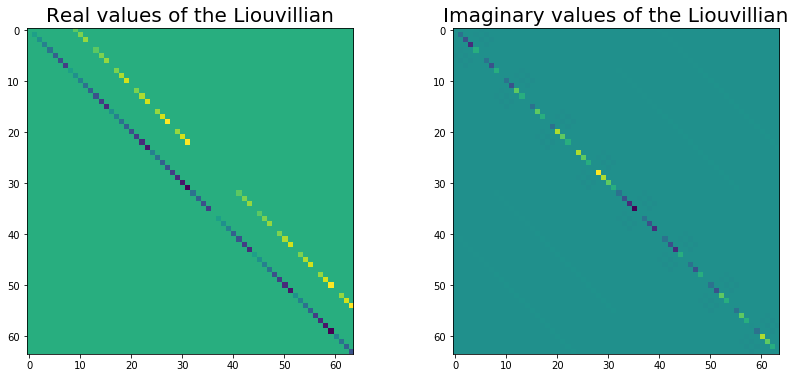

In [8]:
L = liouvillian(H,[np.sqrt(kappa)*a,np.sqrt(gamma)*sz])

# represent the Liouvillian
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(np.real(L.full()))
plt.title("Real values of the Liouvillian",fontsize=fs)
plt.subplot(122)
plt.imshow(np.imag(L.full()))
plt.title("Imaginary values of the Liouvillian",fontsize=fs)
plt.show()
plt.close()

### Liouvillian Spectrum, $\texttt{eigenstates}$

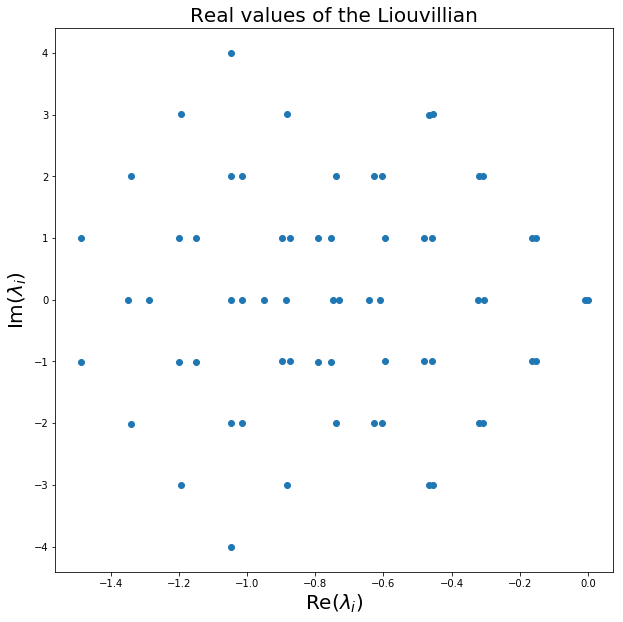

In [9]:
L = liouvillian(H,[np.sqrt(kappa)*a,np.sqrt(gamma)*sz])

# Plot the Liouvillian spectrum in the complex plane
eigenvalues_L, eigenvectors_L = L.eigenstates()


real_eigenvalues = np.real(eigenvalues_L)
imag_eigenvalues = np.imag(eigenvalues_L)

plt.figure(figsize=(10,10))
plt.plot(real_eigenvalues, imag_eigenvalues,"o")
plt.title("Real values of the Liouvillian",fontsize=fs)
plt.ylabel("Im($\lambda_i$)",fontsize=fs)
plt.xlabel("Re($\lambda_i$)",fontsize=fs)
plt.show()
plt.close()

Let us decipher the spectrum of the Liouvillian:

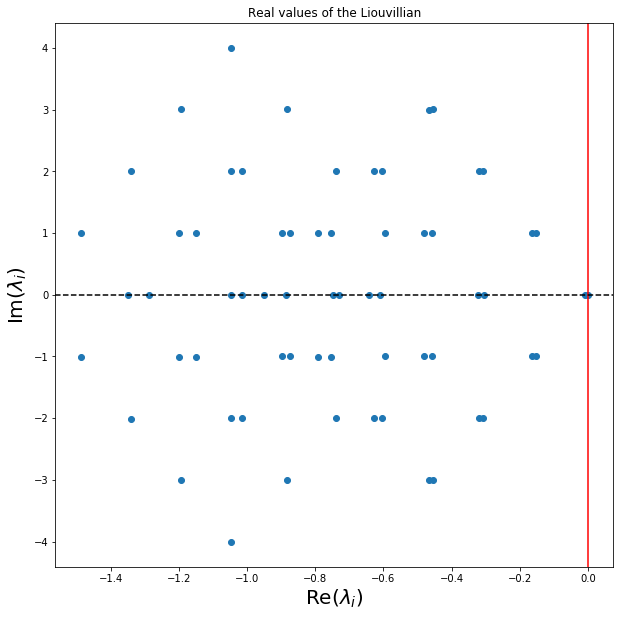

In [10]:
plt.figure(figsize=(10,10))
plt.plot(real_eigenvalues, imag_eigenvalues,"o")
plt.title("Real values of the Liouvillian")
plt.axvline(x=0,color="red")
plt.axhline(y=0,color="black",linestyle="dashed")
plt.ylabel("Im($\lambda_i$)",fontsize=fs)
plt.xlabel("Re($\lambda_i$)",fontsize=fs)
plt.show()
plt.close()

We find symmetries in the Liouvillian spectrum with respect to the real and imaginary axis.

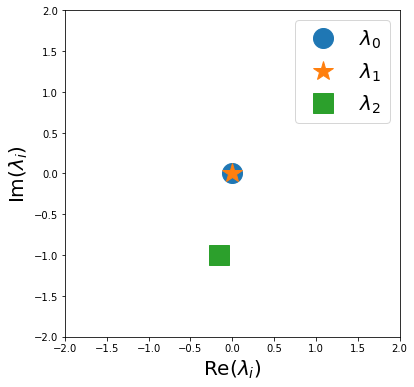

In [11]:
plt.figure(figsize=(6,6))
plt.plot(real_eigenvalues[-1],imag_eigenvalues[-1],"o",markersize=20,label="$\lambda_0$")
plt.plot(real_eigenvalues[-2],imag_eigenvalues[-2],"*",markersize=20,label="$\lambda_1$")
plt.plot(real_eigenvalues[-3],imag_eigenvalues[-3],"s",markersize=20,label="$\lambda_2$")
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.legend(fontsize=20)
plt.ylabel("Im($\lambda_i$)",fontsize=fs)
plt.xlabel("Re($\lambda_i$)",fontsize=fs)
plt.show()
plt.close()

### Photon counting statistics: $\texttt{mcsolve}$

In [12]:
# set dynamics options
my_options = Options(average_states = False, store_states = True)
# solve dynamics
results_mc = mcsolve(H, psi0, tlist, 
                  c_ops=[np.sqrt(kappa)*a,np.sqrt(gamma)*sz], 
                  e_ops=[a.dag()*a,sz], 
                  options=my_options, progress_bar=True)

# store time evoluted variables
nph_mc_t = results_mc.expect[0]
sz_mc_t = results_mc.expect[1]

10.0%. Run time:   4.65s. Est. time left: 00:00:00:41
20.0%. Run time:   9.36s. Est. time left: 00:00:00:37
30.0%. Run time:  14.29s. Est. time left: 00:00:00:33
40.0%. Run time:  19.73s. Est. time left: 00:00:00:29
50.0%. Run time:  27.13s. Est. time left: 00:00:00:27
60.0%. Run time:  32.55s. Est. time left: 00:00:00:21
70.0%. Run time:  37.79s. Est. time left: 00:00:00:16
80.0%. Run time:  42.91s. Est. time left: 00:00:00:10
90.0%. Run time:  48.88s. Est. time left: 00:00:00:05
100.0%. Run time:  54.61s. Est. time left: 00:00:00:00
Total run time:  54.67s


The default options for $\texttt{mcsolve}$ imply solving the dynamics for 500 trajectories. 

This option can be controlled by setting a different number in $\texttt{Options(ntraj=500})$.

In [13]:
rho_mc_t = results_mc.states
len(rho_mc_t)
#help(expect)

500

In [14]:
sz_stoch_t = []
nph_stoch_t = []
for i in range(len(rho_mc_t)):
    sz_stoch_t.append(expect(sz,rho_mc_t[i]))
    nph_stoch_t.append(expect(a.dag()*a,rho_mc_t[i]))

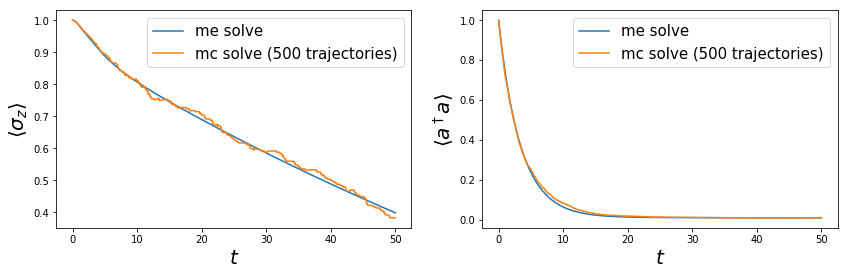

In [15]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(tlist, sz_t, label="me solve")
plt.plot(tlist, sz_mc_t, label="mc solve (500 trajectories)")
plt.xlabel(r"$t$",fontsize=fs)
plt.ylabel(r"$\langle \sigma_z \rangle$",fontsize=fs)
plt.legend(fontsize=15)
plt.subplot(122)
plt.plot(tlist, nph_t/nph/0.5, label="me solve")
plt.plot(tlist, nph_mc_t/nph/0.5, label="mc solve (500 trajectories)")
plt.xlabel(r"$t$",fontsize=fs)
plt.ylabel(r"$\langle a^\dagger a \rangle$",fontsize=fs)
plt.legend(fontsize=15)
plt.show()
plt.close()


### Lindblad master equation as the limit of the stochastic evolution: $\texttt{mesolve}$ and $\texttt{mcsolve}$

In [16]:
# 50 trajectories
my_options50 = Options(ntraj=50)
results_mc50 = mcsolve(H, psi0, tlist, c_ops=[np.sqrt(kappa)*a,np.sqrt(gamma)*sz], 
                  e_ops=[a.dag()*a,sz], options=my_options50, progress_bar=True)
nph_mc_t50 = results_mc50.expect[0]
sz_mc_t50 = results_mc50.expect[1]
# 100 trajectories
my_options100 = Options(ntraj=100)
results_mc100 = mcsolve(H, psi0, tlist, c_ops=[np.sqrt(kappa)*a,np.sqrt(gamma)*sz], 
                  e_ops=[a.dag()*a,sz], options=my_options100, progress_bar=True)
nph_mc_t100 = results_mc100.expect[0]
sz_mc_t100 = results_mc100.expect[1]
# 200 trajectories
my_options200 = Options(ntraj=200)
results_mc200 = mcsolve(H, psi0, tlist, c_ops=[np.sqrt(kappa)*a,np.sqrt(gamma)*sz], 
                  e_ops=[a.dag()*a,sz], options=my_options200, progress_bar=True)
nph_mc_t200 = results_mc200.expect[0]
sz_mc_t200 = results_mc200.expect[1]

10.0%. Run time:   0.36s. Est. time left: 00:00:00:03
20.0%. Run time:   0.53s. Est. time left: 00:00:00:02
30.0%. Run time:   0.74s. Est. time left: 00:00:00:01
40.0%. Run time:   0.90s. Est. time left: 00:00:00:01
50.0%. Run time:   1.09s. Est. time left: 00:00:00:01
60.0%. Run time:   1.26s. Est. time left: 00:00:00:00
70.0%. Run time:   1.45s. Est. time left: 00:00:00:00
80.0%. Run time:   1.63s. Est. time left: 00:00:00:00
90.0%. Run time:   1.82s. Est. time left: 00:00:00:00
100.0%. Run time:   2.00s. Est. time left: 00:00:00:00
Total run time:   2.12s
10.0%. Run time:   0.40s. Est. time left: 00:00:00:03
20.0%. Run time:   0.76s. Est. time left: 00:00:00:03
30.0%. Run time:   1.14s. Est. time left: 00:00:00:02
40.0%. Run time:   1.52s. Est. time left: 00:00:00:02
50.0%. Run time:   1.96s. Est. time left: 00:00:00:01
60.0%. Run time:   2.33s. Est. time left: 00:00:00:01
70.0%. Run time:   2.72s. Est. time left: 00:00:00:01
80.0%. Run time:   3.11s. Est. time left: 00:00:00:00
90.

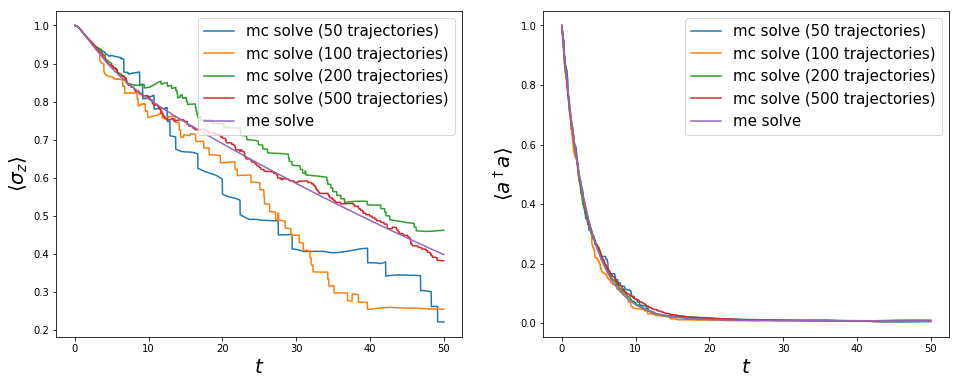

In [17]:
plt.figure(figsize=(16,6))
# spin excitation
plt.subplot(121)
plt.plot(tlist, sz_mc_t50, label="mc solve (50 trajectories)")
plt.plot(tlist, sz_mc_t100, label="mc solve (100 trajectories)")
plt.plot(tlist, sz_mc_t200, label="mc solve (200 trajectories)")
plt.plot(tlist, sz_mc_t, label="mc solve (500 trajectories)")
plt.plot(tlist, sz_t, label="me solve")
plt.xlabel(r"$t$",fontsize=fs)
plt.ylabel(r"$\langle \sigma_z \rangle$",fontsize=fs)
plt.legend(fontsize=15)
# photonic excitation
plt.subplot(122)
plt.plot(tlist, nph_mc_t50/nph/0.5, label="mc solve (50 trajectories)")
plt.plot(tlist, nph_mc_t100/nph/0.5, label="mc solve (100 trajectories)")
plt.plot(tlist, nph_mc_t200/nph/0.5, label="mc solve (200 trajectories)")
plt.plot(tlist, nph_mc_t/nph/0.5, label="mc solve (500 trajectories)")
plt.plot(tlist, nph_t/nph/0.5, label="me solve")
plt.xlabel(r"$t$",fontsize=fs)
plt.ylabel(r"$\langle a^\dagger a \rangle$",fontsize=fs)
plt.legend(fontsize=15)
plt.show()
plt.close()


We observe that progressively, as the number of trajectories is increased, the value given by the average over the trajectories gets closer to the master equation value.

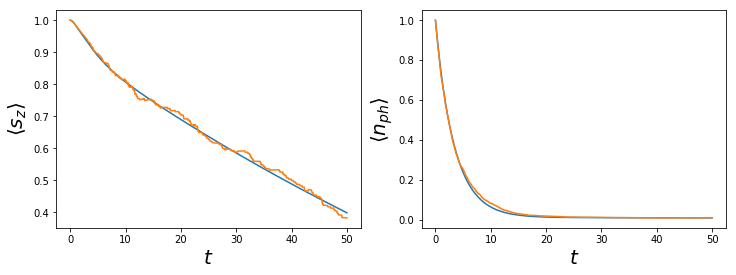

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tlist, sz_t)
plt.plot(tlist, sz_mc_t)
plt.xlabel(r"$t$",fontsize=fs)
plt.ylabel(r"$\langle s_z \rangle$",fontsize=fs)
plt.subplot(122)
plt.plot(tlist, nph_t/nph/0.5)
plt.plot(tlist, nph_mc_t/nph/0.5)

plt.xlabel(r"$t$",fontsize=fs)
plt.ylabel(r"$\langle n_{ph} \rangle$",fontsize=fs)
plt.show()
plt.close()

### Plotting single quantum trajectories

By setting:
my_options = Options(average_states = False, store_states = True)

we can inspect single quantum trajectories and their behaviour.

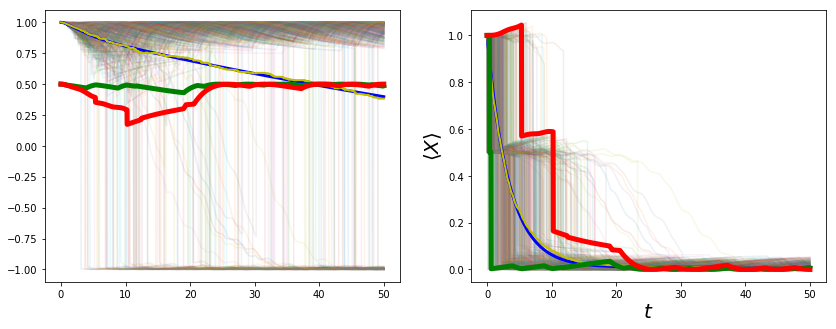

In [19]:
plt.figure(figsize=(14,5))
plt.subplot(121)
for i in range(len(sz_stoch_t)):
    plt.plot(tlist, sz_stoch_t[i],alpha=0.1)

plt.plot(tlist, sz_t,"b",linewidth=3)
plt.plot(tlist, sz_mc_t,"y",linewidth=2)
plt.plot(tlist, sz_stoch_t[4]/nph/0.5,"g",linewidth=5)
plt.plot(tlist, sz_stoch_t[6]/nph/0.5,"r",linewidth=5)
plt.subplot(122)
for i in range(len(sz_stoch_t)):
    plt.plot(tlist, nph_stoch_t[i]/nph/0.5,alpha=0.1)
plt.plot(tlist, nph_t/nph/0.5,"b",linewidth=3)
plt.plot(tlist, nph_mc_t/nph/0.5,"y",linewidth=2)
plt.plot(tlist, nph_stoch_t[4]/nph/0.5,"g",linewidth=5)
plt.plot(tlist, nph_stoch_t[6]/nph/0.5,"r",linewidth=5)
plt.xlabel(r"$t$",fontsize=fs)
plt.ylabel(r"$\langle X \rangle$",fontsize=fs)
plt.show()
plt.close()

We obseverve that the single trajectories can provide information about the phase of the system. In presence of a phase transition the quantum trajectory jumps between possible choices of the degenerate steady state. 

In [21]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
A. J. Pitchford, P. D. Nation, R. J. Johansson, A. Grimsmo, and C. Granade

QuTiP Version:      4.3.1
Numpy Version:      1.15.4
Scipy Version:      1.2.1
Cython Version:     0.29.8
Matplotlib Version: 3.0.3
Python Version:     3.7.3
Number of CPUs:     2
BLAS Info:          OPENBLAS
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Darwin (x86_64)
Installation path:  /miniconda3/lib/python3.7/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex file can be easily generated using `qutip.cite()`
